In [1]:
import os
import csv

samples = []
with open('./data_mouse/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print('Done')




Done


In [2]:
##Validate I'm getting what I expect from train_samples
testName = './data_mouse/IMG/' + train_samples[300][0].split('\\')[-1]
testAngle = float(train_samples[300][3])
print('testName: ', testName, '; testAngle: ', testAngle)

testName:  ./data_mouse/IMG/center_2017_02_12_00_35_42_848.jpg ; testAngle:  -0.02830189


In [3]:
##Double checking on my angles. I wanted to know how many additional images I was adding by duplicating images with steering 
## values greater than 0.2, which I do in the generator
import numpy as np
origAngles =[]
allAngles = []
for line in train_samples:
    origAngles.append(float(line[3]))
    allAngles.append(float(line[3]))
    if float(line[3]) > 0.2:
        allAngles.append(float(line[3])*-1)
npOrigAngles = np.array(origAngles)
npAllAngles = np.array(allAngles)
print('npAngles orig shape: ', npOrigAngles.shape)
print('npAngles All shape: ', npAllAngles.shape)
print('unique values: ' , np.unique(npAllAngles).shape)

npAngles orig shape:  (7808,)
npAngles All shape:  (8492,)
unique values:  (163,)


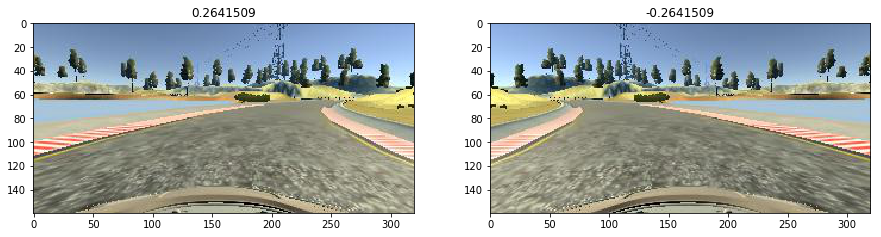

In [6]:
##Ensure image and steering angle flipping is working correctly
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
center_name = './data_mouse/IMG/center_2017_02_12_00_31_28_894.jpg'
center_image = cv2.imread(center_name)
center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
center_angle = float(0.2641509)
image_flipped = np.fliplr(center_image)
reversed_angle = -center_angle
fig, axs = plt.subplots(1,2, figsize=(15, 6))
axs[0].imshow(center_image)
axs[0].set_title(center_angle)
axs[1].imshow(image_flipped)
axs[1].set_title(reversed_angle)

In [6]:
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle
##Notice how I am grabbing the left/right camera images as well. The value camera_angle_offset determines how much steering
##angle should be applied given the offset. I had a lack of data with large steering angles, so I flipped all images/angles with
##a steering angle greater than 0.2 and added them to the training data set.
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Used as a reference pointer so code always loops back around
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            camera_angle_offset = 0.1
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_name = './data_mouse/IMG/' + batch_sample[0].split('\\')[-1]
                left_name = './data_mouse/IMG/' + batch_sample[1].split('\\')[-1]
                right_name = './data_mouse/IMG/' + batch_sample[2].split('\\')[-1]
                center_image = cv2.imread(center_name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                left_image = cv2.imread(left_name)
                left_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                right_image = cv2.imread(right_name)
                right_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                center_angle = float(batch_sample[3])
                left_angle = float(batch_sample[3]) + camera_angle_offset
                right_angle = float(batch_sample[3]) - camera_angle_offset
                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)
                if abs(center_angle) > 0.2:
                    center_image_flipped = np.fliplr(center_image)
                    center_reversed_angle = -center_angle
                    left_image_flipped = np.fliplr(left_image)
                    left_reversed_angle = -left_angle
                    right_image_flipped = np.fliplr(right_image)
                    right_reversed_angle = -right_angle
                    images.append(center_image_flipped)
                    angles.append(center_reversed_angle)
                    images.append(left_image_flipped)
                    angles.append(left_reversed_angle)
                    images.append(right_image_flipped)
                    angles.append(right_reversed_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            X_train = X_train[:,65:145,:,:] 
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)
print('Done')


Done


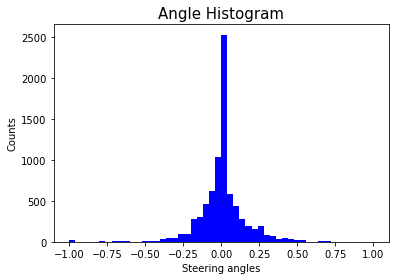

In [12]:
#Histogram of angles before any additional data generation
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(npOrigAngles, bins= 50, color= 'blue', linewidth=0.1)
plt.title('Angle Histogram', fontsize=15)
plt.xlabel('Steering angles')
plt.ylabel('Counts')
plt.show()

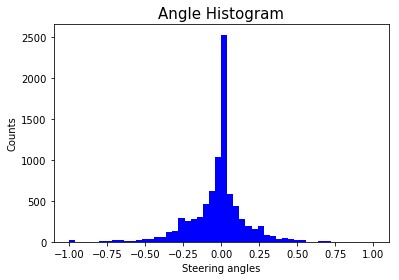

In [13]:
#Histogram of angles after additional data generation
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(npAllAngles, bins= 50, color= 'blue', linewidth=0.1)
plt.title('Angle Histogram', fontsize=15)
plt.xlabel('Steering angles')
plt.ylabel('Counts')
plt.show()
    

Shape: (160, 320, 3)
Two images shape:  (2, 160, 320, 3)
Two images reshaped:  (2, 80, 320, 3)


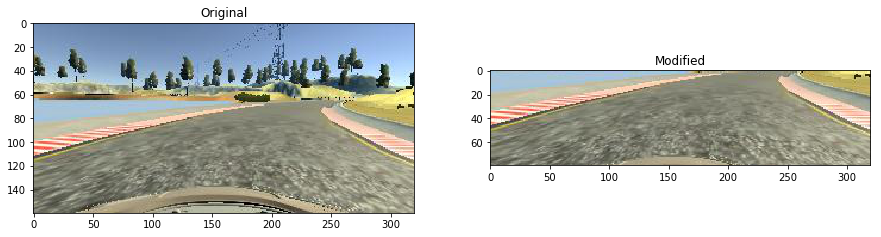

In [15]:
#I used this for testing purposes only. I wanted to visualize the horizontal slice I was grabbing from the image.
#I wanted to exclude some of the hood, and some of the sky/horizon.
import matplotlib.pyplot as plt
%matplotlib inline
sampleImage = cv2.imread('./data_mouse/IMG/center_2017_02_12_00_31_28_894.jpg')
sampleImage = cv2.cvtColor(sampleImage,cv2.COLOR_BGR2RGB)
sampleImage2 = cv2.imread('./data_mouse/IMG/center_2017_02_12_00_31_28_894.jpg')
sampleImage2 = cv2.cvtColor(sampleImage2,cv2.COLOR_BGR2RGB)
print('Shape:' , sampleImage.shape)
imagesTest = []
imagesTest.append(sampleImage)
imagesTest.append(sampleImage2)
npImagesTest = np.array(imagesTest)
print('Two images shape: ' , npImagesTest.shape)
npImagesTestReshaped = npImagesTest[:,65:145,:,:]
print('Two images reshaped: ' , npImagesTestReshaped.shape)
fig, axs = plt.subplots(1,2, figsize=(15, 6))
axs[0].imshow(npImagesTest[0])
axs[0].set_title('Original')
axs[1].imshow(npImagesTestReshaped[0])
axs[1].set_title('Modified')


In [8]:
##This was just to set a variable to count how many additional images I was adding to the training dataset
additionalDataCount = 0
for line in train_samples:
    if abs(float(line[3])) > 0.2:
        additionalDataCount+=1
additionalDataCount *= 3
print('Additional images added: ' , additionalDataCount)

Additional images added:  3261


In [ ]:
# compile and train the model using the generator function
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import load_model
total_samples = len(train_samples)*3 + additionalDataCount
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

row, col, ch, = 80, 320, 3  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=(row, col, ch),
        output_shape=(row, col, ch)))

model.add(Convolution2D(24, 5, 5, border_mode='same', activation='relu', name = 'Conv1'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='same'))
model.add(Convolution2D(36, 5, 5, border_mode='same', activation='relu', name = 'Conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='same'))
model.add(Convolution2D(48, 5, 5, border_mode='same', activation='relu', name = 'Conv3'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='same'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', name = 'Conv4'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='same'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', name = 'Conv5'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='same'))
model.add(Flatten())
model.add(Dense(500, activation='relu', name='FC1'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu', name='FC2'))
model.add(Dropout(0.4))
model.add(Dense(10, name='FC3'))
model.add(Dense(1))
model.summary()


model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, samples_per_epoch=total_samples, validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=6, initial_epoch=0)
model.save('./model.h5')

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 80, 320, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 80, 320, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 40, 160, 24)   0           Conv1[0][0]                      
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 40, 160, 36)   21636       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [7]:
##Testing my saved model
from keras.models import load_model
model = load_model('model.h5')

leftAngle = cv2.imread('./data_mouse/IMG/center_2017_02_12_00_31_28_894.jpg')
steering_angle = float(model.predict(leftAngle[None, 65:145, :, :], batch_size=1))
print('Steering Angle: ', steering_angle)

Using TensorFlow backend.


Steering Angle:  0.19686278700828552
